In [1]:
cd ..

/Users/flamholz/Documents/workspace/ccm_evolution


In [2]:
mkdir -p figures/fig2

In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import pyplot as plt
from hnea_genes import *

In [4]:
locus2plot = [g for g, props in genes_of_interest.items()
              if categories2plot.get(props['kind'], False)]

barseq_df = pd.read_csv('data/Hnea/barseq/fit_logratios_all_good.csv')
barseq_df

,locus_id,5% CO2,ambient CO2,5% CO2.1,ambient CO2.1,0.5% CO2,10% CO2,0.5% CO2.1,10% CO2.1,1.5% CO2,5% CO2.2,1.5% CO2.1,5% CO2.3
0,GFF1190,-0.000402,0.021627,-0.001932,0.076393,-0.062972,-0.044107,-0.097597,-0.114159,0.039218,0.022432,0.003704,-0.027252
1,GFF1209,0.222629,-0.117649,-0.130837,-0.047011,-0.087761,-0.134193,0.154560,-0.038279,0.168402,0.069838,0.227850,-0.037395
2,GFF1357,-0.612701,-0.344187,-0.504753,-0.315189,-1.174064,-0.906337,-1.203053,-0.942894,-1.133942,-1.033053,-1.031073,-1.220323
3,GFF1439,-0.277288,-0.268327,-0.234944,-0.290411,0.117596,-0.007212,0.229604,0.198248,-0.147151,-0.079903,-0.161343,-0.110442
4,GFF1496,0.676934,0.320859,0.515599,0.189416,-0.795918,-0.274587,-0.364849,-0.181126,0.111388,-0.022536,-0.053180,-0.028839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,HNEAP_RS12530,-0.027772,0.062316,-0.142976,-0.040603,0.123303,-0.002187,-0.124067,-0.115389,-0.066936,-0.057656,0.106591,0.084842
1724,HNEAP_RS12535,0.082261,0.042696,-0.150697,-0.186738,0.030698,0.249321,-0.207117,-0.179693,-0.193136,-0.260248,-0.041744,0.054070
1725,HNEAP_RS12550,-0.125825,0.017962,0.086862,0.037113,0.009698,-0.016191,-0.020960,0.047237,-0.011401,0.112636,0.156611,0.071176
1726,HNEAP_RS12555,-0.214570,-0.132329,-0.150477,-0.105451,-0.171533,-0.317492,0.079793,-0.091958,-0.124034,-0.003969,0.043375,-0.072267


In [5]:
# Make a long-form version of the barseq data as it's simpler for seaborn plotting.
numeric_cols = (barseq_df.dtypes == np.float64)
long_df = barseq_df.melt('locus_id', value_vars=barseq_df.columns[numeric_cols])

# Add categorical information.
default_props = dict(kind='other', name=None)
gene_tags = [genes_of_interest.get(row.locus_id, default_props)['kind'] 
             for _, row in long_df.iterrows()]
gene_names = [genes_of_interest.get(row.locus_id, default_props)['name'] 
              for _, row in long_df.iterrows()]

# Strip the .1 suffix in the condition name that comes from melt().
conds = [re.sub('CO2.\d+', 'CO2', row.variable) for _, row in long_df.iterrows()]

# Number the replicates for every condition
pattern = re.compile(r'CO2.(\d+)')
rep = [pattern.findall(row.variable) or ['0'] for _, row in long_df.iterrows()]
rep = [int(i[0]) for i in rep]

# Save everything in the DF.
long_df['gene_tag'] = gene_tags
long_df['gene_name'] = gene_names
long_df['cond'] = conds
long_df['rep'] = rep
long_df['ccm_gene'] = long_df['gene_tag'] != 'other' 

# Shorter data frame for faster plotting of main-text genes.
mask = long_df.locus_id.isin(genes_of_interest.keys())
long_subset_df_allreps = long_df[mask]

# Only plot 2 replicates per CO2 cond. 
# We have 4 reps for 5%, but it makes the plot more confusing.
mask = np.logical_and(mask, long_df.rep < 3)
long_subset_df = long_df[mask]

long_subset_df.head()

,locus_id,variable,value,gene_tag,gene_name,cond,rep,ccm_gene
192,HNEAP_RS01030,5% CO2,-0.009401,transport,DAB2B,5% CO2,0,True
193,HNEAP_RS01035,5% CO2,0.052684,transport,DAB2A,5% CO2,0,True
194,HNEAP_RS01040,5% CO2,0.104180,regulation,LysR DAB2,5% CO2,0,True
648,HNEAP_RS04565,5% CO2,0.015781,carboxysome,csos1D,5% CO2,0,True
650,HNEAP_RS04575,5% CO2,-0.129304,chaperone,cbbQ,5% CO2,0,True


In [6]:
# Calculate the IQR of fitness measurements for each of the CO2 conditions
median_fitness_series = long_df.groupby('cond').median()['value'].rename('median')
bot_fitness_series  = long_df.groupby('cond').quantile(0.25)['value'].rename('bottom')
top_fitness_series = long_df.groupby('cond').quantile(0.75)['value'].rename('top')
tmp = pd.concat([median_fitness_series, bot_fitness_series, top_fitness_series], axis=1)

# Across the whole dataset
median_fitness = long_df.value.median()
bot_quartile_fitness = long_df.value.quantile(0.25)
top_quartile_fitness = long_df.value.quantile(0.75)
print('Median fitness value over all experiments %.3g' % median_fitness)
print('IQR = (%.3g, %.3g)' % (bot_quartile_fitness, top_quartile_fitness))

print('Per CO2 condition')
tmp

Median fitness value over all experiments -0.0231
IQR = (-0.148, 0.0648)
Per CO2 condition


,median,bottom,top
cond,,,
0.5% CO2,-0.017437,-0.140040,0.077791
1.5% CO2,-0.033340,-0.170428,0.054025
10% CO2,-0.015358,-0.135522,0.073933
5% CO2,-0.027191,-0.149242,0.056724
ambient CO2,-0.021527,-0.147207,0.068630


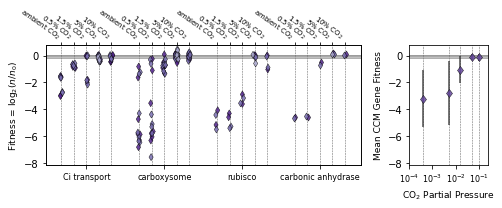

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3), gridspec_kw={'width_ratios': [4,1]})
hue_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
xorder = 'transport,carboxysome,carboxysomal rubisco,CA'.split(',')
pal = sns.color_palette('Purples', n_colors=8)
greys = sns.color_palette('Greys')

plt.sca(axs[0])
for rep in long_subset_df.rep.unique():
    mask = long_subset_df.rep == rep
    my_df = long_subset_df[mask]
    sns.stripplot(data=my_df, x='gene_tag', y='value', hue='cond', dodge=0.25,
                  order=xorder, hue_order=hue_order, alpha=0.85,
                  marker='d', edgecolor='k', linewidth=0.5, palette=[pal[-2*rep-1]])

ax = plt.gca()
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=ax.get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])
plt.legend().set_visible(False)

xticks = 'Ci transport,carboxysome,rubisco,carbonic anhydrase'.split(',')
plt.xticks(np.arange(len(xticks)), xticks, rotation=0, ha='center', fontsize=8)
plt.ylabel('Fitness = $\log_2 (n/n_0)$', fontsize=9)
plt.xlabel('')

xticks = np.arange(0, 0.8, 0.16) - 0.32
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3])
xticks_str = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*4
for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
plt.ylim(-8.15, 0.8)

ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xticks(xticks, xticks_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)
plt.xlim(ax.get_xlim())

# Right panel - mean fitness effect
plt.sca(axs[1])
plt.xscale('log')

# Band for typical mutational effect.
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=axs[1].get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])

# Mean effect for CCM genes
mean_per_cond = long_subset_df.groupby('cond').mean()
std_per_cond = long_subset_df.groupby('cond').std()
str2co2level = {'0.5% CO2':0.5e-2, '1.5% CO2':1.5e-2, '10% CO2':10e-2, '5% CO2':5e-2, 'ambient CO2':0.04e-2}
co2_levels = [str2co2level[x] for x in mean_per_cond.index]
plt.errorbar(co2_levels, mean_per_cond.value, yerr=std_per_cond.value,
             marker='d', markersize=6, markeredgecolor='k', markeredgewidth=0.5, alpha=0.85,
             ls='', ecolor=greys[-1], markerfacecolor=pal[-2])

xs = np.logspace(-4, -1, 4)
plt.xticks(xs, fontsize=8)
plt.xlim(1e-4, 0.25)
plt.ylim(-8.15, 0.8)
plt.xlabel('CO$_2$ Partial Pressure', fontsize=9)
plt.ylabel('Mean CCM Gene Fitness', fontsize=9)

for xpos in co2_levels:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
plt.tight_layout()
    
plt.savefig('figures/fig2/fig2.png', dpi=600, facecolor='w')
plt.show()

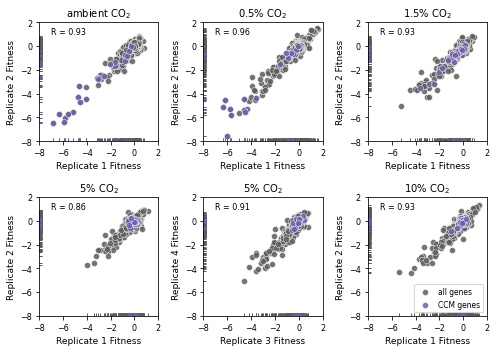

In [8]:
reps = range(1)
conds = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,5% CO2,10% CO2'.split(',')
reps = [(0, 1), (0, 1), (0, 1), (0, 1), (2, 3), (0, 1)]
titles = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*7
greys = sns.color_palette('Greys')
purples = sns.color_palette('Purples')


fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7,5))

for i, (ax, cond) in enumerate(zip(axs.flatten(), conds)):
    plt.sca(ax)
    
    rep1, rep2 = reps[i]
    mask1 = np.logical_and(long_df.cond == cond, long_df.rep == rep1)
    mask2 = np.logical_and(long_df.cond == cond, long_df.rep == rep2)
    sub_df1 = long_df[mask1].set_index('locus_id').sort_index()
    sub_df2 = long_df[mask2].set_index('locus_id').sort_index()
    
    # Remove genes with NAN fitness values
    no_nans = np.logical_and(np.isfinite(sub_df1.value), 
                             np.isfinite(sub_df2.value))
    sub_df1 = sub_df1[no_nans]
    sub_df2 = sub_df2[no_nans]
    
    # Put correlation on the plot
    R = np.corrcoef(sub_df1.value, sub_df2.value)
    txt = 'R = {0:.2f}'.format(R[1,0])
    plt.text(0.1, 0.9, txt, fontsize=8,
             transform=ax.transAxes)
    
    plt.scatter(sub_df1.value, sub_df2.value, color=greys[-2], edgecolor='w',
                lw=0.5, alpha=0.85, label='all genes')
    sns.rugplot(x=sub_df1.value, y=sub_df2.value, color=greys[-2])

    ccm_genes1 = sub_df1.ccm_gene == True
    ccm_genes2 = sub_df2.ccm_gene == True
    plt.scatter(sub_df1[ccm_genes1].value, sub_df2[ccm_genes2].value,
                color=purples[-2], edgecolor='w', lw=0.5, alpha=0.85,
                label='CCM genes')
    sns.rugplot(x=sub_df1[ccm_genes1].value, y=sub_df2[ccm_genes2].value,
                color=purples[-2])
    
    plt.xlabel('Replicate {0} Fitness'.format(rep1 + 1), fontsize=9)
    plt.ylabel('Replicate {0} Fitness'.format(rep2 + 1), fontsize=9)
    plt.title(titles[i], fontsize=10)
    plt.xlim(-8, 2)
    plt.ylim(-8, 2)
    plt.xticks(np.arange(-8, 2.1, 2), fontsize=8)
    plt.yticks(np.arange(-8, 2.1, 2), fontsize=8)
    
plt.legend(loc=4, fontsize=7.5)
plt.tight_layout()
plt.savefig('figures/fig2/fig2_S1.png', dpi=600, facecolor='w')
plt.show()

In [9]:
# Can't plot pairwise data with biological duplicates, so we take the mean fitness per-gene first.
mean_fitness_df = long_df.groupby(['locus_id', 'cond']).mean().reset_index()
mean_fitness_df = mean_fitness_df.pivot('locus_id', 'cond')['value']

# Add categorical information.
default_props = dict(kind='other', name=None)
gene_tags = [genes_of_interest.get(locus_id, default_props)['kind'] 
             for locus_id, row in mean_fitness_df.iterrows()]
gene_names = [genes_of_interest.get(locus_id, default_props)['name'] 
              for locus_id, row in mean_fitness_df.iterrows()]
mean_fitness_df['gene_tag'] = gene_tags
mean_fitness_df['gene_name'] = gene_names
mean_fitness_df['ccm_gene'] = mean_fitness_df['gene_tag'] != 'other'

# Determine the order of plotting manually so that the interesting genes go on top in scatter plots below
tag_order = 'other,transport,carboxysome,carboxysomal rubisco,CA,regulation,chaperone,non-carboxysomal rubisco'.split(',')
tag_order = dict((tag, i) for i, tag in enumerate(tag_order))
mean_fitness_df['gene_tag_order'] = [tag_order[g] for g in mean_fitness_df['gene_tag']]
mean_fitness_df.sort_values('gene_tag_order', ascending=True, inplace=True)

mean_fitness_df.head()

cond,0.5% CO2,1.5% CO2,10% CO2,5% CO2,ambient CO2,gene_tag,gene_name,ccm_gene,gene_tag_order
locus_id,,,,,,,,,
GFF1190,-0.080285,0.021461,-0.079133,-0.001788,0.049010,other,None,False,0
HNEAP_RS08360,-0.499066,-0.549026,-0.801773,-0.252179,-0.273166,other,None,False,0
HNEAP_RS08355,-0.018733,0.019661,-0.068799,-0.061447,-0.021375,other,None,False,0
HNEAP_RS08350,-0.017921,0.094072,0.116095,-0.032568,-0.011143,other,None,False,0
HNEAP_RS08345,-0.035667,0.016089,0.011404,0.051005,0.064591,other,None,False,0


/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/flamholz/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

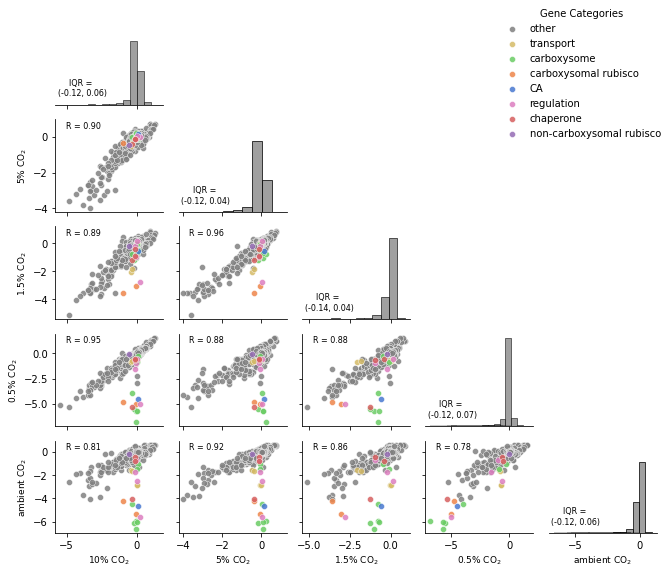

In [10]:
co2_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')[::-1]
co2_labels = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')[::-1]

# muted has a grey in it - drop it
tmp_pal = sns.color_palette('muted', n_colors=9)
tmp_pal = tmp_pal[:7] + tmp_pal[-1:]

tags = sorted(mean_fitness_df.gene_tag.unique())
pal = dict((c, tmp_pal[i]) for i, c in enumerate(tags))
pal['other'] = 'grey'

def my_histplot(x, **kwargs):
    my_kwargs = kwargs.copy()
    my_kwargs['color'] = kwargs['palette'][0]
    sns.histplot(x, **my_kwargs)
    
    if kwargs['label'] == 'other':
        bot_quartile_fitness = x.quantile(0.25)
        top_quartile_fitness = x.quantile(0.75)
        ax = plt.gca()
        txt = 'IQR = \n({0:.2f}, {1:.2f})'.format(bot_quartile_fitness, top_quartile_fitness)
        plt.text(0.25, 0.1, txt, fontsize=8,
                 transform=ax.transAxes, ha='center')
        
def my_scatterplot(x, y, **kwargs):
    my_kwargs = kwargs.copy()
    my_kwargs['color'] = kwargs['palette'][kwargs['label']]
    sns.scatterplot(x, y, **my_kwargs)
    
    if kwargs['label'] == 'other':
        mask = np.logical_not(np.logical_or(np.isnan(x), np.isnan(y)))
        R = np.corrcoef(x[mask].values, y[mask].values)
        ax = plt.gca()
        txt = 'R = {0:.2f}'.format(R[1,0])
        plt.text(0.1, 0.9, txt, fontsize=8,
                 transform=ax.transAxes)

g = sns.PairGrid(mean_fitness_df, vars=co2_order, hue='gene_tag', corner=True)
g.fig.set_size_inches(7,8)
g.map_diag(my_histplot, palette=['grey']*8, binwidth=0.5)
g.map_lower(my_scatterplot, palette=pal, edgecolors='k', linewidths=0.5, alpha=0.85)
g = g.add_legend(fontsize=10, loc=1, title='Gene Categories')

for ylabel, ax in zip(co2_labels, g.axes[:,0]):
    ax.set_ylabel(ylabel, fontsize=9)
for xlabel, ax in zip(co2_labels, g.axes[-1,:]):
    ax.set_xlabel(xlabel, fontsize=9)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S2.png', dpi=600, facecolor='w')
plt.show()

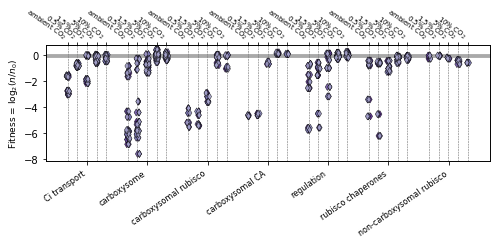

In [11]:
# Longer version of the main-text figure.
hue_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
xorder = 'transport,carboxysome,carboxysomal rubisco,CA,regulation,chaperone,non-carboxysomal rubisco'.split(',')
pal = sns.color_palette('Purples', n_colors=12)
greys = sns.color_palette('Greys')

ls_df = long_subset_df_allreps

fig, ax = plt.subplots(figsize=(7,3.5))

for rep in ls_df.rep.unique():
    mask = ls_df.rep == rep
    my_df = ls_df[mask]
    sns.stripplot(data=ls_df, x='gene_tag', y='value', hue='cond', dodge=0.25,
                  order=xorder, hue_order=hue_order, alpha=0.85,
                  marker='d', edgecolor='k', linewidth=0.5, palette=[pal[-2*rep-1]],
                  jitter=0.15)
    
plt.legend().set_visible(False)

xtick_str = 'Ci transport,carboxysome,carboxysomal rubisco,carboxysomal CA,regulation,rubisco chaperones,non-carboxysomal rubisco'.split(',')
plt.xticks(np.arange(len(xtick_str)), xtick_str, rotation=35, ha='right', fontsize=8)
plt.ylabel('Fitness = $\log_2 (n/n_0)$', fontsize=9)
plt.xlabel('')
plt.ylim(-8.15, 0.8)

# Band for typical mutational effect.
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=ax.get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])

xticks = np.arange(0, 0.8, 0.16) - 0.325
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4, xticks+5, xticks+6])
xticks_str = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')*7

for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])

ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xlim(ax.get_xlim())
plt.xticks(xticks, xticks_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S3.png', dpi=600, facecolor='w')
plt.show()

In [12]:
# Calculate correlation of fitness with pCO2 for all genes
from scipy.stats import pearsonr
cols = ['ambient CO2', '0.5% CO2', '1.5% CO2', '5% CO2', '10% CO2' ]
co2_conc_pct = np.array([0.04, 0.5, 1.5, 5, 10])

annot_df = pd.read_csv('data/Hnea/barseq/2017_11_03_miseq_barSeq1/genes', sep='\t', index_col=0)

corr_df = annot_df.merge(mean_fitness_df, left_index=True, right_index=True)
corr_df['CO2_Rval'] = np.NaN
corr_df['CO2_Pval'] = np.NaN

for idx, row in mean_fitness_df.iterrows():
    gene_fitness = np.array(row[cols].values, dtype=np.float32)
    if np.isnan(gene_fitness).any():
        continue
        
    Rval, p = pearsonr(co2_conc_pct, gene_fitness)
    corr_df.at[idx, 'CO2_Rval'] = Rval
    corr_df.at[idx, 'abs_CO2_Rval'] = np.abs(Rval)
    corr_df.at[idx, 'CO2_Pval'] = p

In [13]:
corr_df['mean_effect_size'] = np.abs(corr_df[cols].mean(axis=1))
mask = np.logical_and(corr_df['CO2_Pval'] < 0.2, corr_df['mean_effect_size'] > 0.3)
masked_corr_df = corr_df[mask]

masked_corr_df.to_csv('data/Hnea/fitness_correlated_with_CO2.csv', index=True)

In [14]:
# CCM genes should have large effect sizes correlated with pCO2
cols2show = 'gene_name,desc,mean_effect_size,abs_CO2_Rval,CO2_Pval,mean_effect_size'.split(',')
corr_df[corr_df.ccm_gene].sort_values('mean_effect_size')[cols2show].round(3).head(20)

,gene_name,desc,mean_effect_size,abs_CO2_Rval,CO2_Pval,mean_effect_size
HNEAP_RS05505,cbbM,ribulose-bisphosphate carboxylase,0.290,0.933,0.021,0.290
HNEAP_RS04565,csos1D,microcompartments protein,0.368,0.773,0.125,0.368
HNEAP_RS04575,cbbQ,CbbQ/NirQ/NorQ/GpvN family protein,0.397,0.869,0.056,0.397
HNEAP_RS04600,cbbO,VWA domain-containing protein,0.442,0.700,0.188,0.442
HNEAP_RS04620,csos1B,major carboxysome shell protein 1B,0.503,0.712,0.177,0.503
HNEAP_RS04610,mcdA,ParA family protein,0.568,0.872,0.054,0.568
HNEAP_RS01040,LysR DAB2,LysR family transcriptional regulator,0.576,0.552,0.335,0.576
HNEAP_RS01030,DAB2B,DUF2309 domain-containing protein,0.711,0.570,0.315,0.711
HNEAP_RS01035,DAB2A,NADH dehydrogenase subunit 5,0.731,0.562,0.324,0.731
HNEAP_RS07320,Crp/Fnr,hypothetical protein,0.761,0.716,0.174,0.761


In [15]:
# Get all genes with fittness effect and correlation at least as high as any CCM gene
cols2show = 'gene_name,desc,ccm_gene,mean_effect_size,abs_CO2_Rval,CO2_Pval,mean_effect_size'.split(',')
mask = np.logical_and(corr_df.abs_CO2_Rval > 0.55, corr_df.mean_effect_size > 0.5)
corr_df[mask].sort_values('abs_CO2_Rval', ascending=False)[cols2show].round(3)

,gene_name,desc,ccm_gene,mean_effect_size,abs_CO2_Rval,CO2_Pval,mean_effect_size
HNEAP_RS11630,None,chromosome partitioning protein ParB,False,1.023,0.952,0.013,1.023
HNEAP_RS11640,None,16S rRNA (guanine(527)-N(7))-methyltransferase...,False,0.597,0.945,0.015,0.597
HNEAP_RS11300,None,phosphate regulon transcriptional regulatory p...,False,0.835,0.935,0.020,0.835
HNEAP_RS11635,None,ParA family protein,False,1.427,0.934,0.020,1.427
HNEAP_RS07755,None,phytoene synthase,False,0.810,0.926,0.024,0.810
HNEAP_RS07855,None,ribosome small subunit-dependent GTPase A,False,3.439,0.889,0.044,3.439
HNEAP_RS04660,cbbL,ribulose bisphosphate carboxylase large chain,True,2.693,0.887,0.045,2.693
HNEAP_RS05490,LysR,LysR family transcriptional regulator,True,2.648,0.886,0.045,2.648
HNEAP_RS04905,None,leucyl aminopeptidase,False,1.358,0.879,0.049,1.358
HNEAP_RS04505,None,hypothetical protein,False,0.541,0.876,0.051,0.541


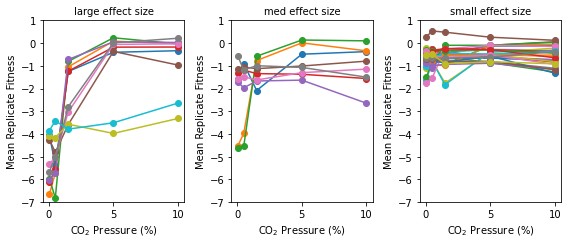

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(8,3.5))

pal = sns.color_palette(n_colors=masked_corr_df.shape[0])

large_effect = masked_corr_df[masked_corr_df.mean_effect_size > 2]
mask = np.logical_and(masked_corr_df.mean_effect_size > 1, 
                      masked_corr_df.mean_effect_size <= 2)
med_effect = masked_corr_df[mask]
small_effect = masked_corr_df[masked_corr_df.mean_effect_size <= 1]
titles = 'large effect size,med effect size,small effect size'.split(',')

for i, (my_df, my_ax) in enumerate(zip([large_effect, med_effect, small_effect], axs)):
    plt.sca(my_ax)
    plt.xlabel('CO$_2$ Pressure (%)')
    plt.ylabel('Mean Replicate Fitness')
    plt.ylim(-7, 1)
    plt.title(titles[i], fontsize=10)
    for j, (idx, row) in enumerate(my_df.iterrows()):
        plt.plot(co2_conc_pct, row[cols], color=pal[j], label=idx, ls='-', marker='o')

plt.tight_layout()
plt.savefig('figures/fig2/fitness_corr_co2.png', facecolor='w', dpi=600)
plt.show()